In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io
import os, sys
import tqdm
from scipy.optimize import curve_fit
from pathlib import Path
import pickle

In [4]:
# Import local tools
sys.path.append(os.path.expanduser('~/Desktop/Analysis/kohl-lab-pynalysis/'))
from pynalysis import utils

In [5]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso

In [6]:
def split_dataset(dataset, split=0.8, shuffle=False):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [7]:
def fuse_dataset(data, labels, standardize=True):
    d = data.reshape((data.shape[0],-1))
    if standardize:
        scaler = sklearn.preprocessing.Normalizer()
#         scaler = sklearn.preprocessing.MinMaxScaler()
#         scaler = sklearn.preprocessing.MinMaxScaler()
        d = scaler.fit_transform(d)
    return d,labels

In [8]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

# Load data

In [9]:
# Load external list of animals and experiments
experiments = pd.read_csv("~/Desktop/Analysis/kohl-lab-pynalysis/meta_data/MULTIBAR-animal-list.csv")

In [10]:
# Load preprocessed data from zipped pickle
data_packs = utils.load_zipped_pickle(os.path.expanduser("~/Desktop/Results/preprocessed/preprocessed_data.pkl.gz"))

In [11]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores



def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1.0)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

# Extract accuracy with SVM

In [12]:
# Load datapacks run SVM and create pandas dataframe with the results
records = []
for area in data_packs:
    for plane in range(2):
        data = area['plane_data'][plane]['datatensor']
        labels = area["labels"]

        string_identifier = "%s/%s/plane%i"%(area["stringid"],area["expspecifier"],plane+1)
        print(string_identifier)
        
        nb_stimuli = len(np.unique(labels))
        chance_level = 1.0/nb_stimuli

        # perform min max scaling on a per neuron basis
        # mi = area["plane_data"][plane]['traces'].min(0)
        # ma = area["plane_data"][plane]['traces'].max(0)
        # sd = area["plane_data"][plane]['traces'].std(0)
        # data = (data-mi)/(ma-mi+1e-7)
        # data = data/(sd+1e-7)
        
        # check for nan in data
        if np.isnan(data.mean()):
            print("Warning dataset contains NAN. Skipping...")
            continue

        # Process time averaged trial data
        tmp = data[:,15:45,:]
        acc_total = get_acc_all_times(tmp, labels)
        print("some",acc_total.mean(),acc_total.std())
        acc_some_mean_score  = acc_total.mean()
        acc_some_var_score   = acc_total.var()

        # Compute classification accuracy on average over those bins
        tmp = data[:,15:45,:].mean(1,keepdims=True)
        acc_total = get_acc_all_times(tmp, labels)
        print("avg",acc_total.mean(),acc_total.std())
        acc_avg_mean_score  = acc_total.mean()
        acc_avg_var_score   = acc_total.var()

        
        # import fields from experiments CSV file
        ex = experiments.loc[area["index"]]
        
        # combine results to record
        rec = dict( stringid=area["stringid"], 
                    exp_date=area["exp_date"], 
                    area_name=area["area_name"],
                    plane_number=plane+1,
                    nb_stimuli=nb_stimuli,
                    chance_level=chance_level,
                    svm_acc_mean=acc_avg_mean_score, 
                    svm_acc_var=acc_avg_var_score,
                    svm_acc_some_mean=acc_some_mean_score, 
                    svm_acc_some_var=acc_some_var_score,
                    mean_velocity=area['mean_trial_velocity'].mean(),
                    plane1_layer=ex["plane1_layer"],
                    plane2_layer=ex["plane2_layer"],
                    nb_stim_pos=ex["nb_pos"],
                    nb_stim_speed=ex["nb_speed"],
                    indicator=ex["indicator_name"],
                    comments=ex["comments"],
                  )
        
        records.append(rec)
        
df = pd.DataFrame(records)

CGCC8.5a/date_2018_02_08/area1/plane1
some 0.927272727273 0.0616575453011
avg 0.816017316017 0.0856224091088
CGCC8.5a/date_2018_02_08/area1/plane2
some 0.981385281385 0.0228085538915
avg 0.981818181818 0.0222680885708
CGCC8.5a/date_2018_02_08/area2/plane1
some 0.769090909091 0.102304035612
avg 0.741818181818 0.0644365278061
CGCC8.5a/date_2018_02_08/area2/plane2
some 0.667272727273 0.0853964986605
avg 0.66 0.0922805639305
CGCC8.5a/date_2018_02_08/area3/plane1
some 0.896926406926 0.0811517326868
avg 0.878744588745 0.0762409317389
CGCC8.5a/date_2018_02_08/area3/plane2
some 0.961818181818 0.0369945271807
avg 0.943636363636 0.0737204906644
CGCC8.5a/date_2018_02_08/area4/plane1
some 0.758008658009 0.0858671949314
avg 0.702164502165 0.0911520151567
CGCC8.5a/date_2018_02_08/area4/plane2
some 0.916883116883 0.0781214380946
avg 0.869696969697 0.0775894777601
CGCC8.5a/date_2018_02_08/area5/plane1
some 0.594545454545 0.0855898348796
avg 0.603636363636 0.108269635862
CGCC8.5a/date_2018_02_08/area5/

# Stimulus decoding accuracy for different depths

In [13]:
# Select all with 4 pos and single speed


In [14]:
def get_depth_acc(sel):
        
    l23data = sel.loc[ (df["plane1_layer"]==2) & (df["plane2_layer"]==3) ]
    l33data = sel.loc[ (df["plane1_layer"]==3) & (df["plane2_layer"]==3) ]

    depth1data = l23data.loc[df["plane_number"]==1]
    depth3data = l23data.loc[df["plane_number"]==2]

    depth2data = l33data.loc[df["plane_number"]==1]
    depth4data = l33data.loc[df["plane_number"]==2]

    depthdata = [depth1data, depth2data, depth3data, depth4data]
    
    return depthdata

In [22]:
sel = df.loc[ (df["nb_stim_speed"]==1) & (df["nb_stim_pos"]==2) ]

depthdata = get_depth_acc(sel)
means2 = [ dat.mean()["svm_acc_mean"] for dat in depthdata ]
ns2 = [ len(dat) for dat in depthdata ]
stdevs2 = [ np.sqrt(dat.sum()["svm_acc_var"])/ns2[i] for i,dat in enumerate(depthdata) ]


sel = df.loc[ (df["nb_stim_speed"]==1) & (df["nb_stim_pos"]==4) ]

depthdata = get_depth_acc(sel)
means4 = [ dat.mean()["svm_acc_mean"] for dat in depthdata ]
ns4 = [ len(dat) for dat in depthdata ]
stdevs4 = [ np.sqrt(dat.sum()["svm_acc_var"])/ns4[i] for i,dat in enumerate(depthdata) ]


In [23]:
x=range(len(means2))
plt.errorbar(x, means2, yerr=stdevs2, fmt="o-", label=r"n_stim=2")

x=range(len(means4))
plt.errorbar(x, means4, yerr=stdevs4, fmt="o-", label=r"n_stim=4")

# here errorbars are stdev
plt.xlabel("Pseudodepth")
plt.ylabel("Accuracy")
plt.legend()
sns.despine()

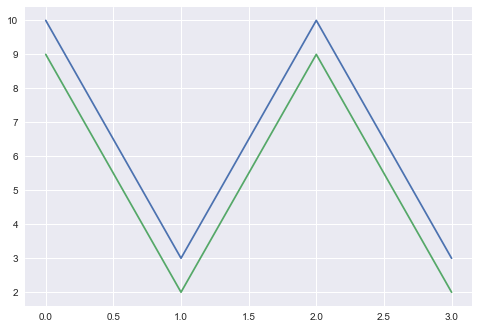

In [27]:
x=range(len(means2))
plt.plot(x, ns2, label=r"n_stim=2")

x=range(len(means4))
plt.plot(x, ns4, label=r"n_stim=4")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14b1c9ba8>]], dtype=object)

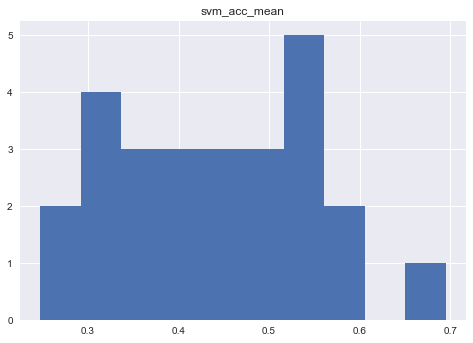

In [25]:
sel.hist(column="svm_acc_mean")

# Below we select runs which are significantly above chance level

Not sure this is entirely kosher, but of course we are pulling our mean down if a given areay doesn't encode anything ...

In [20]:
above_chance = df.loc[df["svm_acc_mean"]-3*np.sqrt(df["svm_acc_var"])>df["chance_level"]]
sel = above_chance.loc[ (above_chance["nb_stim_speed"]==1) & (above_chance["nb_stim_pos"]==2) ]
depthdata = get_depth_acc(sel)
means2 = [ dat.mean()["svm_acc_mean"] for dat in depthdata ]
ns2 = [ len(dat) for dat in depthdata ]
stdevs2 = [ np.sqrt(dat.sum()["svm_acc_var"])/ns2[i] for i,dat in enumerate(depthdata) ]


sel = above_chance.loc[ (above_chance["nb_stim_speed"]==1) & (above_chance["nb_stim_pos"]==4) ]

depthdata = get_depth_acc(sel)
means4 = [ dat.mean()["svm_acc_mean"] for dat in depthdata ]
ns4 = [ len(dat) for dat in depthdata ]
stdevs4 = [ np.sqrt(dat.sum()["svm_acc_var"])/ns4[i] for i,dat in enumerate(depthdata) ]


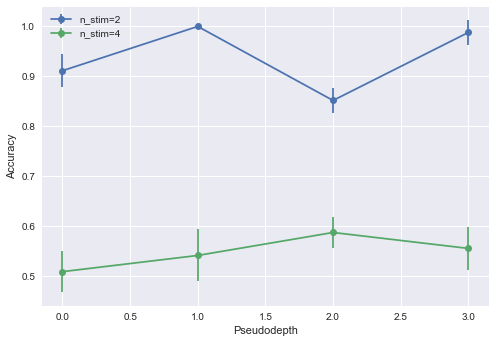

In [21]:
x=range(len(means2))
plt.errorbar(x, means2, yerr=stdevs2, fmt="o-", label=r"n_stim=2")

x=range(len(means4))
plt.errorbar(x, means4, yerr=stdevs4, fmt="o-", label=r"n_stim=4")

# here errorbars are stdev
plt.xlabel("Pseudodepth")
plt.ylabel("Accuracy")
plt.legend()
sns.despine()